In [ ]:
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import pandas as pd
import os

class WhiteBalanceDatasetTest(Dataset):
    def __init__(self, csv_path, img_dir, transform=None, train=True):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['names'])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            raise FileNotFoundError(f"–ù–µ —É–¥–∞–ª–æ—Å—å –∑–∞–≥—Ä—É–∑–∏—Ç—å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ: {img_path}")
        img = img.astype(np.float32)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
        img = img / 65535.0  # –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è RAW –≤ [0,1]
        img = cv2.resize(img, (224, 224))  # EfficientNet –æ–∂–∏–¥–∞–µ—Ç –º–∏–Ω–∏–º—É–º 224√ó224
        img = torch.from_numpy(img).permute(2, 0, 1)  # HWC ‚Üí CHW

        if self.train:
            label = torch.tensor([row['wp_r'], row['wp_g'], row['wp_b']], dtype=torch.float32)
            return img, label
        else:
            return img, row['names']

In [ ]:
from pathlib import Path

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

class WhiteBalanceDataset(Dataset):
    def __init__(self, csv_path, img_dir, hist_dir, transform=None, train=True, use_hist=True):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.hist_dir = hist_dir
        self.transform = transform
        self.train = train
        self.use_hist = use_hist

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # === –ó–∞–≥—Ä—É–∂–∞–µ–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ ===
        img_path = os.path.join(self.img_dir, row['image_name'])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            raise FileNotFoundError(f"–ù–µ —É–¥–∞–ª–æ—Å—å –∑–∞–≥—Ä—É–∑–∏—Ç—å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ: {img_path}")
        img = img.astype(np.float32) / 65535.0
        img = cv2.resize(img, (224, 224))
        img = torch.from_numpy(img).permute(2, 0, 1)  # HWC ‚Üí CHW

        # === –ó–∞–≥—Ä—É–∂–∞–µ–º –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º—É (–µ—Å–ª–∏ –Ω—É–∂–Ω–æ) ===
        hist_tensor = None
        if self.use_hist and self.hist_dir is not None:
            hist_path = os.path.join(self.hist_dir, row['image_name'])
            if not os.path.exists(hist_path):
                raise FileNotFoundError(f"–ù–µ —É–¥–∞–ª–æ—Å—å –∑–∞–≥—Ä—É–∑–∏—Ç—å –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º—É: {hist_path}")

            hist = cv2.imread(hist_path, cv2.IMREAD_GRAYSCALE)
            hist = hist.astype(np.float32) / 255.0  # –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è [0,1]
            hist = cv2.resize(hist, (128, 128))
            hist_tensor = torch.from_numpy(hist).unsqueeze(0)  # (1, 128, 128)

        # === –í–æ–∑–≤—Ä–∞—â–∞–µ–º –¥–∞–Ω–Ω—ã–µ ===
        if self.train:
            label = torch.tensor([row['wp_r'], row['wp_g'], row['wp_b']], dtype=torch.float32)
            if self.use_hist and hist_tensor is not None:
                return img, hist_tensor, label
            else:
                return img, label
        else:
            if self.use_hist and hist_tensor is not None:
                return img, hist_tensor, row['image_name']
            else:
                return img, row['image_name']


In [ ]:
def create_compatible_csv(existing_csv_path, output_csv_path):
    """–°–æ–∑–¥–∞–µ—Ç CSV —Ñ–∞–π–ª —Å –∏–º–µ–Ω–∞–º–∏ —Ñ–∞–π–ª–æ–≤ –±–µ–∑ –ø—Ä–µ—Ñ–∏–∫—Å–∞ –ø—É—Ç–∏"""
    df = pd.read_csv(existing_csv_path)

    # –ò–∑–≤–ª–µ–∫–∞–µ–º —Ç–æ–ª—å–∫–æ –∏–º–µ–Ω–∞ —Ñ–∞–π–ª–æ–≤ –±–µ–∑ –ø—É—Ç–µ–π
    if 'names' in df.columns:
        df['image_name'] = df['names'].apply(lambda x: Path(x).stem +'.png')
    else:
        # –ü—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ–º, —á—Ç–æ –ø–µ—Ä–≤–∞—è –∫–æ–ª–æ–Ω–∫–∞ —Å–æ–¥–µ—Ä–∂–∏—Ç –ø—É—Ç–∏
        first_col = df.columns[0]
        df['image_name'] = df[first_col].apply(lambda x: Path(str(x)).stem + '.png')

    # –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ç–æ–ª—å–∫–æ –Ω—É–∂–Ω—ã–µ –∫–æ–ª–æ–Ω–∫–∏
    result_df = df[['image_name', 'wp_r', 'wp_g', 'wp_b']]
    result_df.to_csv(output_csv_path, index=False)
    print(f"Created compatible CSV: {output_csv_path}")
    print(f"Rows: {len(result_df)}")
    return result_df

# –ò—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ
create_compatible_csv("/kaggle/input/testtrain/train (2).csv", "train3.csv")

Created compatible CSV: train3.csv
Rows: 570


image_name      wp_r      wp_g      wp_b
0     0000.png  0.173683  0.508642  0.215429
1     0002.png  0.266894  0.956725  0.577948
2     0004.png  0.146930  0.495538  0.265573
3     0005.png  0.218046  0.712538  0.402101
4     0008.png  0.070384  0.183209  0.125570
..         ...       ...       ...       ...
565   0937.png  0.215597  0.226323  0.196691
566   0938.png  0.169317  0.299355  0.544165
567   0939.png  0.105052  0.339278  0.126710
568   0940.png  0.222516  0.693838  0.352222
569   0941.png  0.104517  0.303611  0.170755

[570 rows x 4 columns]

In [ ]:
import pandas as pd

# –ø—É—Ç—å –∫ –∏—Å—Ö–æ–¥–Ω–æ–º—É csv
csv_path = "/kaggle/working/train3.csv"
out_path = "/kaggle/working/train_filtered.csv"

# —á–∏—Ç–∞–µ–º
df = pd.read_csv(csv_path)

print("–î–æ —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏:", df.shape)

# —Ñ–∏–ª—å—Ç—Ä—É–µ–º —Å—Ç—Ä–æ–∫–∏ –≥–¥–µ wp_g != 1.0
df_filtered = df[df["wp_g"] != 1.0].reset_index(drop=True)

print("–ü–æ—Å–ª–µ —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏:", df_filtered.shape)

# —Å–æ—Ö—Ä–∞–Ω—è–µ–º
df_filtered.to_csv(out_path, index=False)
print(f"–°–æ—Ö—Ä–∞–Ω–µ–Ω–æ –≤ {out_path}")


–î–æ —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏: (570, 4)
–ü–æ—Å–ª–µ —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏: (561, 4)
–°–æ—Ö—Ä–∞–Ω–µ–Ω–æ –≤ /kaggle/working/train_filtered.csv


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.models as models
def get_model(name: str, pretrained: bool = False, out_dim: int = 3):
    """
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç model, ready for regression -> out_dim (3) with Sigmoid.
    –ü–æ–¥–¥–µ—Ä–∂–∏–≤–∞–µ–º: 'efficientnet_b0', 'efficientnet_b3', 'resnet50', 'resnet18', 'mobilenet_v3_large'
    """
    name = name.lower()
    if name == "efficientnet_b0":
        m = models.efficientnet_b0(weights='DEFAULT' if pretrained else None)
        # replace classifier
        in_f = m.classifier[1].in_features if hasattr(m, "classifier") else 1280
        m.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m

    if name == "efficientnet_b3":
        m = models.efficientnet_b3(weights='DEFAULT' if pretrained else None)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m

    if name == "resnet50":
        m = models.resnet50(weights='DEFAULT' if pretrained else None)
        in_f = m.fc.in_features
        m.fc = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m

    if name == "resnet18":
        m = models.resnet18(weights='DEFAULT' if pretrained else None)
        in_f = m.fc.in_features
        m.fc = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m

    if name == "mobilenet_v3_large":
        m = models.mobilenet_v3_large(weights='DEFAULT' if pretrained else None)
        in_f = m.classifier[0].in_features if hasattr(m, "classifier") else 1280
        m.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m

    if name == "vit_b_16":
        m = models.vit_b_16(weights="DEFAULT" if pretrained else None)
        in_f = m.heads.head.in_features
        m.heads = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m

    if name == "convnext_base":
        m = models.convnext_base(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier[2].in_features
        m.classifier = nn.Sequential(
            nn.Flatten(1),  # <--- –¥–æ–±–∞–≤–ª—è–µ–º flatten –ø–µ—Ä–µ–¥ LayerNorm
            nn.LayerNorm(in_f, eps=1e-6),
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m


    if name == "convnext_tiny":
        m = models.convnext_tiny(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier[2].in_features
        m.classifier = nn.Sequential(
            nn.LayerNorm(in_f, eps=1e-6),
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m

    if name == "swin_t":
        m = models.swin_t(weights="DEFAULT" if pretrained else None)
        in_f = m.head.in_features
        m.head = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m

    if name == "densenet121":
        m = models.densenet121(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier.in_features
        m.classifier = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m
    if name == "mnasnet1_0":
        m = models.mnasnet1_0(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier[-1].in_features
        m.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m
    if name == "swin_b":
        m = models.swin_b(weights="DEFAULT" if pretrained else None)
        in_f = m.head.in_features
        m.head = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m
    if name == "t2t_vit":
        m = timm.create_model("t2t_vit_14", pretrained=pretrained, num_classes=out_dim)
        m.head = nn.Sequential(
            nn.Linear(m.head.in_features, out_dim),
            nn.Sigmoid()
        )
        return m
    if name == "vit_l_16":  # Vision Transformer Large/16
        m = models.vit_l_16(weights="DEFAULT" if pretrained else None)
        in_f = m.heads.head.in_features
        m.heads = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m
    if name == 'cvt':
        model = timm.create_model("cvt_13", pretrained=pretrained)
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, out_dim)
        return model
    if name == "crossvit_15_240":
        m = timm.create_model("crossvit_15_240", pretrained=pretrained, num_classes=0)

        # –ü–æ–ª—É—á–∞–µ–º —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –æ–±–µ–∏—Ö –≤–µ—Ç–≤–µ–π
        # –°–æ–∑–¥–∞–µ–º —Ç–µ—Å—Ç–æ–≤—ã–π –≤—Ö–æ–¥ –∏ –ø–æ–ª—É—á–∞–µ–º —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç–∏
        test_input = torch.randn(1, 3, 240, 240)
        with torch.no_grad():
            features = m.forward_features(test_input)
            feature_dims = [f.shape[-1] for f in features]

        # –°–æ–∑–¥–∞–µ–º –≥–æ–ª–æ–≤—ã —Å –ø—Ä–∞–≤–∏–ª—å–Ω—ã–º–∏ —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—è–º–∏
        m.head = nn.ModuleList([
            nn.Linear(feature_dims[0], out_dim),
            nn.Linear(feature_dims[1], out_dim)
        ])

    else:
        raise ValueError(f"Unknown model name: {name}")

    return m
    if name == "maxvit_t":
        m = models.maxvit_t(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier[5].in_features  # —É MaxViT classifier = Sequential([... , Linear])
        m.classifier[5] = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m
    if name == "levit":
        m = timm.create_model("levit_128s", pretrained=pretrained, num_classes=out_dim)
        m.head = nn.Sequential(
            nn.Linear(m.head.in_features, out_dim),
            nn.Sigmoid()
        )
        return m
    # --- DeiT —á–µ—Ä–µ–∑ timm ---

    if name == "deit_base":
        timm_name = "deit_base_patch16_224"
    elif name == "deit_small":
        timm_name = "deit_small_patch16_224"
    else:
        timm_name = name  # –µ—Å–ª–∏ –ø–µ—Ä–µ–¥–∞–Ω –ø–æ–ª–Ω—ã–π timm-–∏–º—è

    # –°–æ–∑–¥–∞—ë–º –º–æ–¥–µ–ª—å —Å –Ω—É–∂–Ω—ã–º —á–∏—Å–ª–æ–º –∫–ª–∞—Å—Å–æ–≤ = out_dim (—á—Ç–æ–±—ã –≥–æ–ª–æ–≤–∞ —Å—Ä–∞–∑—É –∏–º–µ–ª–∞ –ø—Ä–∞–≤–∏–ª—å–Ω—É—é —Ñ–æ—Ä–º—É)
    # –ï—Å–ª–∏ pretrained=True ‚Äî timm –ø–æ–ø—ã—Ç–∞–µ—Ç—Å—è –∑–∞–≥—Ä—É–∑–∏—Ç—å –≤–µ—Å–∞
    model = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)

    # timm –æ–±—ã—á–Ω–æ —Å–æ–∑–¥–∞—ë—Ç head –±–µ–∑ Sigmoid; –∑–∞–º–µ–Ω–∏–º –Ω–∞ (Linear -> Sigmoid) –µ—Å–ª–∏ –Ω—É–∂–Ω–æ
    # –£ —Ä–∞–∑–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π –∏–º—è –≥–æ–ª–æ–≤—ã –º–æ–∂–µ—Ç –±—ã—Ç—å 'head' –∏–ª–∏ 'classifier'
    if hasattr(model, "head"):
        # –µ—Å–ª–∏ head ‚Äî –ª–∏–Ω–µ–π–Ω—ã–π, –∑–∞–º–µ–Ω–∏–º –Ω–∞ Sequential
        try:
            in_f = model.head.in_features
            model.head = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        except Exception:
            # –µ—Å–ª–∏ head ‚Äî —É–∂–µ nn.Sequential –∏–ª–∏ –¥—Ä—É–≥–æ–π —Ç–∏–ø, –ø—Ä–æ—Å—Ç–æ –∑–∞–º–µ–Ω–∏–º –ø–æ–ª–Ω–æ—Å—Ç—å—é
            model.head = nn.Sequential(nn.Linear(model.num_features, out_dim), nn.Sigmoid())
    elif hasattr(model, "classifier"):
        try:
            in_f = model.classifier.in_features
            model.classifier = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        except Exception:
            model.classifier = nn.Sequential(nn.Linear(model.num_features, out_dim), nn.Sigmoid())
    else:
        # Last resort: add attribute 'head'
        model.head = nn.Sequential(nn.Linear(model.num_features, out_dim), nn.Sigmoid())

    return model

    raise ValueError(f"Unknown model name: {name}")



In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm

def get_model(name: str, pretrained: bool = False, out_dim: int = 3):
    name = name.lower()

    if name == "efficientnet_b0":
        m = models.efficientnet_b0(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "resnet50":
        m = models.resnet50(weights="DEFAULT" if pretrained else None)
        in_f = m.fc.in_features
        m.fc = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "densenet121":
        m = models.densenet121(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier.in_features
        m.classifier = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m
    elif name == "vit_l_16":  # Vision Transformer Large/16
        m = models.vit_l_16(weights="DEFAULT" if pretrained else None)
        in_f = m.heads.head.in_features
        m.heads = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m
    # -------- timm –º–æ–¥–µ–ª–∏ --------
    elif name in ["deit_base", "deit_small"]:
        timm_name = {
            "deit_base": "deit_base_patch16_224",
            "deit_small": "deit_small_patch16_224",
        }[name]

        m = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)
        # –¥–æ–±–∞–≤–∏–º Sigmoid
        if hasattr(m, "head") and isinstance(m.head, nn.Linear):
            in_f = m.head.in_features
            m.head = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "cvt":
        m = timm.create_model("cvt_13", pretrained=pretrained, num_classes=out_dim)
        return m

    elif name == "maxvit_t":
        m = timm.create_model("maxvit_tiny_tf_224", pretrained=pretrained, num_classes=out_dim)
        return m

    else:
        raise ValueError(f"Unknown model name: {name}")


–°–æ—Ö—Ä–∞–Ω–µ–Ω–æ -> wb_examples/example_1.png


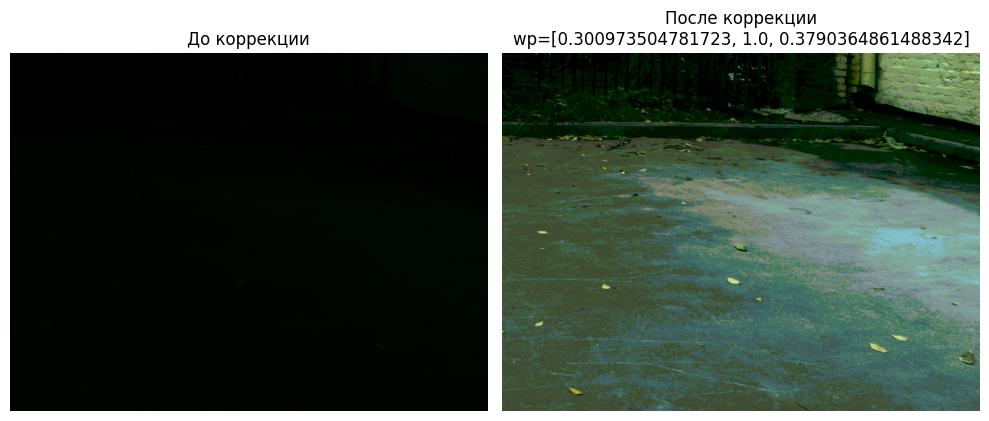

–°–æ—Ö—Ä–∞–Ω–µ–Ω–æ -> wb_examples/example_2.png


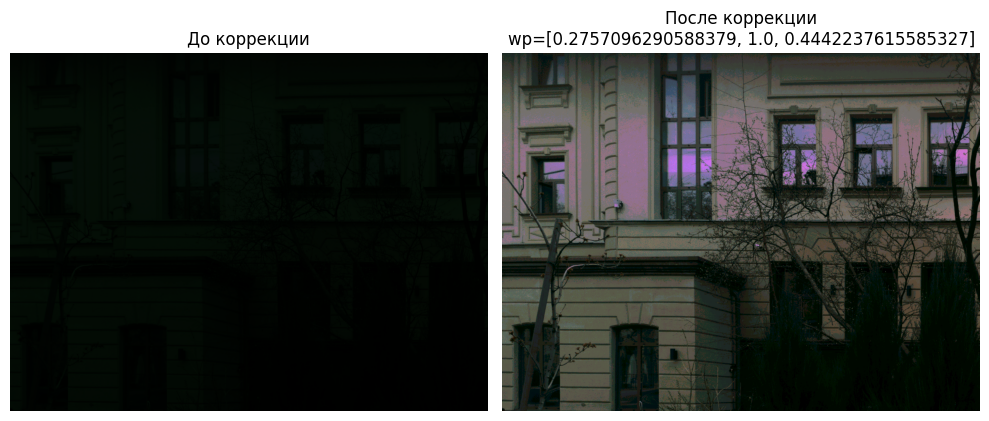

–°–æ—Ö—Ä–∞–Ω–µ–Ω–æ -> wb_examples/example_3.png


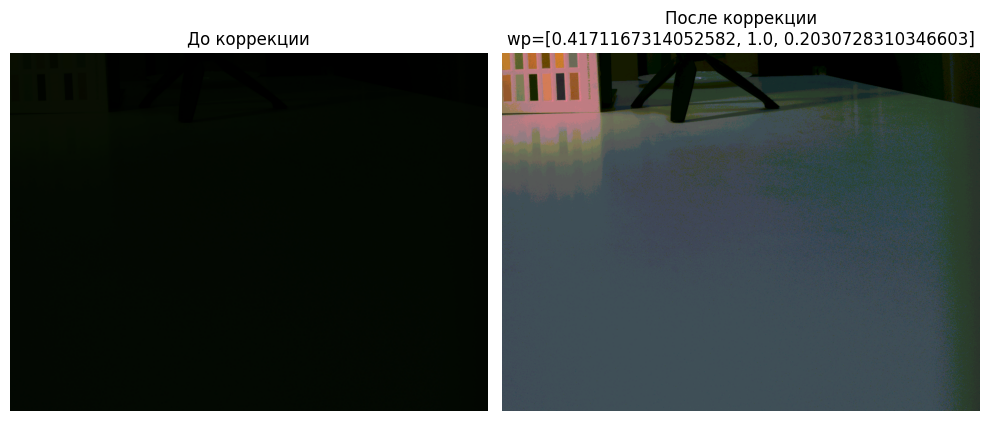

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# =========================
# –§—É–Ω–∫—Ü–∏—è —Ü–≤–µ—Ç–æ–≤–æ–π –∫–æ—Ä—Ä–µ–∫—Ü–∏–∏
# =========================
def apply_white_balance(img: np.ndarray, wp: np.ndarray, out_range=(0, 255)):
    """
    img: numpy array (H, W, 3) –≤ –¥–∏–∞–ø–∞–∑–æ–Ω–µ [0,255] uint8
    wp: numpy array (3,) –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω–∞—è —Ç–æ—á–∫–∞ –±–µ–ª–æ–≥–æ [wp_r, wp_g, wp_b]
    out_range: (min,max) –¥–∏–∞–ø–∞–∑–æ–Ω –≤—ã—Ö–æ–¥–Ω–æ–≥–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è
    """
    img = img.astype(np.float32) / 255.0  # –≤ [0,1]
    wp = np.clip(wp, 1e-6, None)          # –∑–∞—â–∏—Ç–∞ –æ—Ç –¥–µ–ª–µ–Ω–∏—è –Ω–∞ 0

    corrected = img / wp[np.newaxis, np.newaxis, :]  # –ø—Ä–∏–º–µ–Ω—è–µ–º —Ñ–æ—Ä–º—É–ª—É
    corrected = corrected / corrected.max()          # –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è
    corrected = np.clip(corrected, 0, 1)

    if out_range[1] == 255:
        corrected = (corrected * 255).astype(np.uint8)
    return corrected

# =========================
# –î–µ–º–æ–Ω—Å—Ç—Ä–∞—Ü–∏—è
# =========================
def show_before_after(img_path, wp_pred, save_path=None):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    corrected = apply_white_balance(img, np.array(wp_pred))

    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    axes[0].imshow(img)
    axes[0].set_title("–î–æ –∫–æ—Ä—Ä–µ–∫—Ü–∏–∏")
    axes[0].axis("off")
    axes[1].imshow(corrected)
    axes[1].set_title(f"–ü–æ—Å–ª–µ –∫–æ—Ä—Ä–µ–∫—Ü–∏–∏\nwp={wp_pred}")
    axes[1].axis("off")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"–°–æ—Ö—Ä–∞–Ω–µ–Ω–æ -> {save_path}")
    plt.show()

# =========================
# –ü—Ä–∏–º–µ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è
# =========================
# –ü—É—Å—Ç—å —É –Ω–∞—Å –µ—Å—Ç—å 3 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è (—Å —Ä–∞–∑–Ω—ã–º –æ—Å–≤–µ—â–µ–Ω–∏–µ–º) –∏ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –º–æ–¥–µ–ª–∏:
examples = [
    ("/kaggle/input/test-imgs/0001.png", [0.300973504781723, 1.0, 0.3790364861488342]),
    ("/kaggle/input/test-imgs/0015.png", [0.2757096290588379, 1.0, 0.4442237615585327]),
    ("/kaggle/input/test-imgs/0018.png", [0.4171167314052582, 1.0, 0.2030728310346603]),
]

os.makedirs("wb_examples", exist_ok=True)

for i, (img_path, wp_pred) in enumerate(examples, 1):
    save_path = f"wb_examples/example_{i}.png"
    show_before_after(img_path, wp_pred, save_path)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm

def get_model(name: str, pretrained: bool = False, out_dim: int = 3):
    name = name.lower()

    if name == "efficientnet_b0":
        m = models.efficientnet_b0(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "resnet50":
        m = models.resnet50(weights="DEFAULT" if pretrained else None)
        in_f = m.fc.in_features
        m.fc = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "densenet121":
        m = models.densenet121(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier.in_features
        m.classifier = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m
    elif name == "vit_l_16":  # Vision Transformer Large/16
        m = models.vit_l_16(weights="DEFAULT" if pretrained else None)
        in_f = m.heads.head.in_features
        m.heads = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m
 # -------- timm –º–æ–¥–µ–ª–∏ --------
    elif name in ["deit_base", "deit_small"]:
        timm_name = {
            "deit_base": "deit_base_patch16_224",
            "deit_small": "deit_small_patch16_224",
        }[name]

        m = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)
        # –¥–æ–±–∞–≤–∏–º Sigmoid
        if hasattr(m, "head") and isinstance(m.head, nn.Linear):
            in_f = m.head.in_features
            m.head = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "cvt":
        m = timm.create_model("cvt_13", pretrained=pretrained, num_classes=out_dim)
        return m

    elif name == "maxvit_t":
        m = timm.create_model("maxvit_tiny_tf_224", pretrained=pretrained, num_classes=out_dim)
        return m

    elif name.startswith("convit"):
        # convit_tiny, convit_small, convit_base
        timm_name = {
            "convit_tiny": "convit_tiny",
            "convit_small": "convit_small",
            "convit_base": "convit_base",
        }[name]
        m = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)
        if hasattr(m, "head") and isinstance(m.head, nn.Linear):
            in_f = m.head.in_features
            m.head = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name.startswith("levit"):
        # levit_128s, levit_192, levit_256, levit_384 –∏ —Ç.–¥.
        timm_name = name  # –∏–º—è –≤ timm —Å–æ–≤–ø–∞–¥–∞–µ—Ç
        m = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)
        if hasattr(m, "head") and isinstance(m.head, nn.Linear):
            in_f = m.head.in_features
            m.head = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "pit":
        m = timm.create_model("pit_b_224", pretrained=pretrained, num_classes=out_dim)
        m.head = nn.Sequential(
            nn.Linear(m.head.in_features, out_dim),
            nn.Sigmoid()
        )
        return m

    else:
        raise ValueError(f"Unknown model name: {name}")


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm

def get_model(name: str, pretrained: bool = False, out_dim: int = 3):
    name = name.lower()

    if name == "efficientnet_b0":
        m = models.efficientnet_b0(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "resnet50":
        m = models.resnet50(weights="DEFAULT" if pretrained else None)
        in_f = m.fc.in_features
        m.fc = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "densenet121":
        m = models.densenet121(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier.in_features
        m.classifier = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m
    elif name == "vit_l_16":  # Vision Transformer Large/16
        m = models.vit_l_16(weights="DEFAULT" if pretrained else None)
        in_f = m.heads.head.in_features
        m.heads = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m
    # -------- timm –º–æ–¥–µ–ª–∏ --------
    elif name in ["deit_base", "deit_small"]:
        timm_name = {
            "deit_base": "deit_base_patch16_224",
            "deit_small": "deit_small_patch16_224",
        }[name]

        m = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)
        # –¥–æ–±–∞–≤–∏–º Sigmoid
        if hasattr(m, "head") and isinstance(m.head, nn.Linear):
            in_f = m.head.in_features
            m.head = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "cvt":
        m = timm.create_model("cvt_13", pretrained=pretrained, num_classes=out_dim)
        return m

    elif name == "maxvit_t":
        m = timm.create_model("maxvit_tiny_tf_224", pretrained=pretrained, num_classes=out_dim)
        return m
    elif name == "levit":
        m = timm.create_model("levit_128s", pretrained=pretrained, num_classes=out_dim)
        m.head = nn.Sequential(
            nn.Linear(m.head.in_features, out_dim),
            nn.Sigmoid()
        )
        return m
    elif name in ["deit3_base", "deit3_large", "deit3_small", "deit3_tiny"]:
            timm_map = {
                "deit3_base": "deit3_base_patch16_224",
                "deit3_large": "deit3_large_patch16_224",
                "deit3_small": "deit3_small_patch16_224",
                "deit3_tiny": "deit3_tiny_patch16_224",
            }
            timm_name = timm_map[name]

            # —Å–æ–∑–¥–∞—ë–º timm –º–æ–¥–µ–ª—å
            m = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)

            # —É –º–æ–¥–µ–ª–µ–π DeiT III –≥–æ–ª–æ–≤–∞ –æ–±—ã—á–Ω–æ Linear ‚Üí –∑–∞–º–µ–Ω–∏–º –Ω–∞ Linear+Sigmoid
            if hasattr(m, "head") and isinstance(m.head, nn.Linear):
                in_f = m.head.in_features
                m.head = nn.Sequential(
                    nn.Linear(in_f, out_dim),
                    nn.Sigmoid()
                )
            else:
                m.head = nn.Sequential(
                    nn.Linear(m.num_features, out_dim),
                    nn.Sigmoid()
                )
            return m

    else:
            raise ValueError(f"Unknown model name: {name}")

In [ ]:
from torch.utils.data import DataLoader, random_split

In [ ]:
'deit3_base','resnet50','densenet121','deit_base','efficientnet_b0','vit_l_16'

In [ ]:
# train_ensemble.py
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
import numpy as np

# ----------------- –ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è -----------------
MODEL_NAMES = ['deit3_base','resnet50','densenet121','deit_base','efficientnet_b0','vit_l_16']  # –∏–∑–º–µ–Ω—è–π –∫–∞–∫ —Ö–æ—á–µ—à—å'vit_l_16','resnet50','densenet121'
OUT_DIR = "ensemble_checkpoints"
os.makedirs(OUT_DIR, exist_ok=True)

BATCH_SIZE = 12
LR = 1e-4
EPOCHS = 25
TRAIN_CSV = "/kaggle/working/train3.csv"
TRAIN_IMG_DIR = "/kaggle/input/images"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------- –ú–µ—Ç—Ä–∏–∫–∞ / Loss -----------------
def angular_loss(pred, target, eps=1e-7):
    # pred, target: (B,3), not necessarily normalized
    # compute 1 - cos sim as loss
    p = pred / (pred.norm(dim=1, keepdim=True) + eps)
    t = target / (target.norm(dim=1, keepdim=True) + eps)
    cos = (p * t).sum(dim=1).clamp(-1+1e-7, 1-1e-7)
    loss = 1.0 - cos
    return loss.mean()

def eval_metrics(preds, targets):
    # preds, targets numpy arrays (N,3)
    # compute mean angular error (degrees) and median
    eps=1e-7
    p = preds / (np.linalg.norm(preds, axis=1, keepdims=True) + eps)
    t = targets / (np.linalg.norm(targets, axis=1, keepdims=True) + eps)
    cos = np.sum(p * t, axis=1)
    cos = np.clip(cos, -1.0, 1.0)
    ang = np.arccos(cos)  # radians
    deg = np.degrees(ang)
    return deg.mean(), np.median(deg)

# ----------------- Dataset / Dataloaders -----------------
dataset = WhiteBalanceDataset(TRAIN_CSV, TRAIN_IMG_DIR, hist_dir=None, train=True, use_hist=False)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ----------------- Training loop for each model -----------------
for model_name in MODEL_NAMES:
    print(f"\n=== Training {model_name} ===")
    model = get_model(model_name, pretrained=False, out_dim=3).to(device)

    criterion_mse = nn.MSELoss()
    scaler = GradScaler()
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    best_val = float('inf')
    best_ckpt = os.path.join(OUT_DIR, f"{model_name}.pth")

    for epoch in range(1, EPOCHS+1):
        model.train()
        train_losses = []
        for imgs, labels in train_loader:
            imgs = imgs.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            with autocast():
                outs = model(imgs)  # [B,3] in [0,1] due to Sigmoid
                loss_ang = angular_loss(outs, labels)
                loss_mse = criterion_mse(outs, labels)
                loss = 0.6 * loss_ang + 0.4 * loss_mse

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_losses.append(loss.item())

        # validation
        model.eval()
        val_loss_vals = []
        preds_list = []
        targs_list = []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)
                outs = model(imgs)
                loss_ang = angular_loss(outs, labels)
                loss_mse = criterion_mse(outs, labels)
                loss = 0.6 * loss_ang + 0.4 * loss_mse
                val_loss_vals.append(loss.item())
                preds_list.append(outs.cpu().numpy())
                targs_list.append(labels.cpu().numpy())

        val_loss = float(np.mean(val_loss_vals))
        preds_all = np.vstack(preds_list)
        targs_all = np.vstack(targs_list)
        mean_deg, med_deg = eval_metrics(preds_all, targs_all)

        print(f"[{model_name}] Epoch {epoch}/{EPOCHS} train_loss={np.mean(train_losses):.6f} val_loss={val_loss:.6f} mean_deg={mean_deg:.4f} med_deg={med_deg:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val:
            best_val = val_loss
            torch.save({
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "val_loss": val_loss
            }, best_ckpt)
            print(f"Saved best -> {best_ckpt}")

    print(f"Finished training {model_name}. Best val loss: {best_val:.6f}")



=== Training deit3_base ===


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


[deit3_base] Epoch 1/25 train_loss=0.077377 val_loss=0.029124 mean_deg=11.6601 med_deg=9.3464
Saved best -> ensemble_checkpoints/deit3_base.pth


Process Process-2522:
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b6a4192f740>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1582, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 948, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/selectors.py", line 415, in select
    fd_event_list = self._select

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_36/1692494229.py", line 83, in <cell line: 0>
    scaler.step(optimizer)
  File "/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py", line 457, in step
    retval = self._maybe_opt_step(optimizer, optimizer_state, *args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py", line 351, in _maybe_opt_step
    if not sum(v.item() for v in optimizer_state["found_inf_per_device"].values()):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py", line 351, in <genexpr>
    if not sum(v.item() for v in optimizer_state["found_inf_per_device"].values()):
     

TypeError: object of type 'NoneType' has no len()

In [ ]:
# ----------------- –ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è -----------------
MODEL_NAMES = ['deit_base','vit_l_16','pit','resnet50']  # –∏–∑–º–µ–Ω—è–π –∫–∞–∫ —Ö–æ—á–µ—à—å'vit_l_16','resnet50','densenet121'
OUT_DIR = "ensemble_checkpoints"
os.makedirs(OUT_DIR, exist_ok=True)

BATCH_SIZE = 12
LR = 1e-4
EPOCHS = 30
TRAIN_CSV = "/kaggle/working/train_filtered.csv"
TRAIN_IMG_DIR = "/kaggle/input/images"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------- –ú–µ—Ç—Ä–∏–∫–∞ / Loss -----------------
def angular_loss(pred, target, eps=1e-7):
    # pred, target: (B,3), not necessarily normalized
    # compute 1 - cos sim as loss
    p = pred / (pred.norm(dim=1, keepdim=True) + eps)
    t = target / (target.norm(dim=1, keepdim=True) + eps)
    cos = (p * t).sum(dim=1).clamp(-1+1e-7, 1-1e-7)
    loss = 1.0 - cos
    return loss.mean()

def eval_metrics(preds, targets):
    # preds, targets numpy arrays (N,3)
    # compute mean angular error (degrees) and median
    eps=1e-7
    p = preds / (np.linalg.norm(preds, axis=1, keepdims=True) + eps)
    t = targets / (np.linalg.norm(targets, axis=1, keepdims=True) + eps)
    cos = np.sum(p * t, axis=1)
    cos = np.clip(cos, -1.0, 1.0)
    ang = np.arccos(cos)  # radians
    deg = np.degrees(ang)
    return deg.mean(), np.median(deg)

# ----------------- Dataset / Dataloaders -----------------
dataset = WhiteBalanceDataset(TRAIN_CSV, TRAIN_IMG_DIR, hist_dir=None, train=True, use_hist=False)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ----------------- –§—É–Ω–∫—Ü–∏—è –¥–ª—è –∑–∞–≥—Ä—É–∑–∫–∏ –≤–µ—Å–æ–≤ -----------------
def load_checkpoint(model, optimizer, checkpoint_path):
    """–ó–∞–≥—Ä—É–∂–∞–µ—Ç —Å–æ—Ö—Ä–∞–Ω–µ–Ω–Ω—ã–µ –≤–µ—Å–∞ –∏ —Å–æ—Å—Ç–æ—è–Ω–∏–µ –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞"""
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        best_val = checkpoint["val_loss"]
        print(f"Loaded checkpoint with val_loss: {best_val:.6f}")
        return best_val
    else:
        print(f"No checkpoint found at {checkpoint_path}, starting from scratch")
        return float('inf')

# ----------------- Training loop for each model -----------------
for model_name in MODEL_NAMES:
    print(f"\n=== Training {model_name} ===")
    model = get_model(model_name, pretrained=False, out_dim=3).to(device)

    criterion_mse = nn.MSELoss()
    scaler = GradScaler()
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    # –ü—É—Ç—å –∫ —á–µ–∫–ø–æ–∏–Ω—Ç—É
    checkpoint_path = os.path.join(OUT_DIR, f"{model_name}.pth")

    # –ó–∞–≥—Ä—É–∂–∞–µ–º –≤–µ—Å–∞ –µ—Å–ª–∏ –æ–Ω–∏ —Å—É—â–µ—Å—Ç–≤—É—é—Ç
    best_val = load_checkpoint(model, optimizer, checkpoint_path)
    best_ckpt = checkpoint_path

    start_epoch = 1
    # –ï—Å–ª–∏ –∑–∞–≥—Ä—É–∑–∏–ª–∏ —á–µ–∫–ø–æ–∏–Ω—Ç, –º–æ–∂–µ–º –ø—Ä–æ–¥–æ–ª–∂–∏—Ç—å —Å –ø–æ—Å–ª–µ–¥–Ω–µ–π —ç–ø–æ—Ö–∏
    # (–≤ –¥–∞–Ω–Ω–æ–º —Å–ª—É—á–∞–µ –ø—Ä–æ—Å—Ç–æ –ø—Ä–æ–¥–æ–ª–∂–∞–µ–º —Ç—Ä–µ–Ω–∏—Ä–æ–≤–∫—É)

    for epoch in range(start_epoch, EPOCHS+1):
        model.train()
        train_losses = []
        for imgs, labels in train_loader:
            imgs = imgs.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            with autocast():
                outs = model(imgs)  # [B,3] in [0,1] due to Sigmoid
                loss_ang = angular_loss(outs, labels)
                loss_mse = criterion_mse(outs, labels)
                loss = 0.6 * loss_ang + 0.4 * loss_mse

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_losses.append(loss.item())

        # validation
        model.eval()
        val_loss_vals = []
        preds_list = []
        targs_list = []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)
                outs = model(imgs)
                loss_ang = angular_loss(outs, labels)
                loss_mse = criterion_mse(outs, labels)
                loss = 0.6 * loss_ang + 0.4 * loss_mse
                val_loss_vals.append(loss.item())
                preds_list.append(outs.cpu().numpy())
                targs_list.append(labels.cpu().numpy())

        val_loss = float(np.mean(val_loss_vals))
        preds_all = np.vstack(preds_list)
        targs_all = np.vstack(targs_list)
        mean_deg, med_deg = eval_metrics(preds_all, targs_all)

        print(f"[{model_name}] Epoch {epoch}/{EPOCHS} train_loss={np.mean(train_losses):.6f} val_loss={val_loss:.6f} mean_deg={mean_deg:.4f} med_deg={med_deg:.4f}")

        scheduler.step(val_loss)

        if val_loss > 0:
            best_val = val_loss
            torch.save({
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "val_loss": val_loss,
                "epoch": epoch
            }, best_ckpt)
            print(f"Saved best -> {best_ckpt}")

    print(f"Finished training {model_name}. Best val loss: {best_val:.6f}")


=== Training deit_base ===


NameError: name 'GradScaler' is not defined

In [ ]:
import timm

model_names = timm.list_models()  # —Å–ø–∏—Å–æ–∫ –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π, –¥–æ—Å—Ç—É–ø–Ω—ã—Ö –≤ —Ç–≤–æ–µ–π –≤–µ—Ä—Å–∏–∏ timm
# –ø—Ä–∏–º–µ—Ä —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏ –ø–æ "cvt" –∏ "maxvit"
for name in model_names:
    if "segformer" in name.lower() or "segformer" in name.lower():
        print(name)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm

def get_model(name: str, pretrained: bool = False, out_dim: int = 3):
    name = name.lower()

    if name == "efficientnet_b0":
        m = models.efficientnet_b0(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "resnet50":
        m = models.resnet50(weights="DEFAULT" if pretrained else None)
        in_f = m.fc.in_features
        m.fc = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "densenet121":
        m = models.densenet121(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier.in_features
        m.classifier = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "vit_l_16":  # Vision Transformer Large/16 (torchvision)
        m = models.vit_l_16(weights="DEFAULT" if pretrained else None)
        in_f = m.heads.head.in_features  # —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–∞—è –≥–æ–ª–æ–≤–∞
        m.heads.head = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m

    # -------- timm –º–æ–¥–µ–ª–∏ --------
    elif name in ["deit_base", "deit_small"]:
        timm_name = {
            "deit_base": "deit_base_patch16_224",
            "deit_small": "deit_small_patch16_224",
        }[name]

        m = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)
        # –¥–æ–±–∞–≤–∏–º Sigmoid
        if hasattr(m, "head") and isinstance(m.head, nn.Linear):
            in_f = m.head.in_features
            m.head = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "cvt":
        m = timm.create_model("cvt_13", pretrained=pretrained, num_classes=out_dim)
        return m

    elif name == "maxvit_t":
        m = timm.create_model("maxvit_tiny_tf_224", pretrained=pretrained, num_classes=out_dim)
        return m

    else:
        raise ValueError(f"Unknown model name: {name}")


In [ ]:
from pathlib import Path
import pandas as pd

def create_compatible_csv(existing_csv_path, output_csv_path):
    """–°–æ–∑–¥–∞–µ—Ç CSV —Ñ–∞–π–ª —Å –∏–º–µ–Ω–∞–º–∏ —Ñ–∞–π–ª–æ–≤ –±–µ–∑ –ø—Ä–µ—Ñ–∏–∫—Å–∞ –ø—É—Ç–∏ –∏ —Å —Ä–∞—Å—à–∏—Ä–µ–Ω–∏–µ–º .png"""
    df = pd.read_csv(existing_csv_path)

    # –ò–∑–≤–ª–µ–∫–∞–µ–º —Ç–æ–ª—å–∫–æ –∏–º–µ–Ω–∞ —Ñ–∞–π–ª–æ–≤ –∏ –¥–æ–±–∞–≤–ª—è–µ–º .png
    if 'names' in df.columns:
        df['names'] = df['names'].apply(lambda x: Path(str(x)).stem + '.png')
    else:
        # –ü—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ–º, —á—Ç–æ –ø–µ—Ä–≤–∞—è –∫–æ–ª–æ–Ω–∫–∞ —Å–æ–¥–µ—Ä–∂–∏—Ç –ø—É—Ç–∏
        first_col = df.columns[0]
        df['names'] = df[first_col].apply(lambda x: Path(str(x)).stem + '.png')

    # –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ç–æ–ª—å–∫–æ –Ω—É–∂–Ω—ã–µ –∫–æ–ª–æ–Ω–∫–∏
    result_df = df[['names']]
    result_df.to_csv(output_csv_path, index=False)
    print(f"Created compatible CSV: {output_csv_path}")
    print(f"Rows: {len(result_df)}")
    return result_df

# –ò—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ
create_compatible_csv("/kaggle/input/testtrain/test (3).csv", "test3.csv")

Created compatible CSV: test3.csv
Rows: 145


names
0    0001.png
1    0015.png
2    0018.png
3    0019.png
4    0020.png
..        ...
140  0912.png
141  0917.png
142  0924.png
143  0925.png
144  0926.png

[145 rows x 1 columns]

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm

def get_model(name: str, pretrained: bool = False, out_dim: int = 3):
    name = name.lower()

    if name == "efficientnet_b0":
        m = models.efficientnet_b0(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "resnet50":
        m = models.resnet50(weights="DEFAULT" if pretrained else None)
        in_f = m.fc.in_features
        m.fc = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "densenet121":
        m = models.densenet121(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier.in_features
        m.classifier = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m
    elif name == "vit_l_16":  # Vision Transformer Large/16
        m = models.vit_l_16(weights="DEFAULT" if pretrained else None)
        in_f = m.heads.head.in_features
        m.heads = nn.Sequential(
            nn.Linear(in_f, out_dim),
            nn.Sigmoid()
        )
        return m
    # -------- timm –º–æ–¥–µ–ª–∏ --------
    elif name in ["deit_base", "deit_small"]:
        timm_name = {
            "deit_base": "deit_base_patch16_224",
            "deit_small": "deit_small_patch16_224",
        }[name]

        m = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)
        # –¥–æ–±–∞–≤–∏–º Sigmoid
        if hasattr(m, "head") and isinstance(m.head, nn.Linear):
            in_f = m.head.in_features
            m.head = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "cvt":
        m = timm.create_model("cvt_13", pretrained=pretrained, num_classes=out_dim)
        return m

    elif name == "maxvit_t":
        m = timm.create_model("maxvit_tiny_tf_224", pretrained=pretrained, num_classes=out_dim)
        return m
    elif name == "levit":
        m = timm.create_model("levit_128s", pretrained=pretrained, num_classes=out_dim)
        m.head = nn.Sequential(
            nn.Linear(m.head.in_features, out_dim),
            nn.Sigmoid()
        )
        return m
    elif name in ["deit3_base", "deit3_large", "deit3_small", "deit3_tiny"]:
            timm_map = {
                "deit3_base": "deit3_base_patch16_224",
                "deit3_large": "deit3_large_patch16_224",
                "deit3_small": "deit3_small_patch16_224",
                "deit3_tiny": "deit3_tiny_patch16_224",
            }
            timm_name = timm_map[name]

            # —Å–æ–∑–¥–∞—ë–º timm –º–æ–¥–µ–ª—å
            m = timm.create_model(timm_name, pretrained=pretrained, num_classes=out_dim)

            # —É –º–æ–¥–µ–ª–µ–π DeiT III –≥–æ–ª–æ–≤–∞ –æ–±—ã—á–Ω–æ Linear ‚Üí –∑–∞–º–µ–Ω–∏–º –Ω–∞ Linear+Sigmoid
            if hasattr(m, "head") and isinstance(m.head, nn.Linear):
                in_f = m.head.in_features
                m.head = nn.Sequential(
                    nn.Linear(in_f, out_dim),
                    nn.Sigmoid()
                )
            else:
                m.head = nn.Sequential(
                    nn.Linear(m.num_features, out_dim),
                    nn.Sigmoid()
                )
            return m

    else:
            raise ValueError(f"Unknown model name: {name}")

In [ ]:
import torch, random, numpy as np
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [ ]:
import os
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np


MODEL_NAMES = ['resnet50','densenet121','deit_base','efficientnet_b0','deit3_small']
CHECKPOINT_DIR = "/kaggle/working/ensemble_checkpoints"
TEST_CSV = "/kaggle/working/test3.csv"
TEST_IMG_DIR = "/kaggle/input/test-imgs"
SUBMISSION = "submission_ensemble1.csv"
WEIGHTS = None  # e.g. [0.5,0.3,0.2] or None for equal weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataset (image-only)
test_ds = WhiteBalanceDatasetTest(TEST_CSV, TEST_IMG_DIR,train=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=2)

# load models
models1 = []
print(type(models))  # Check what type models is
print(models)
for name in MODEL_NAMES:
    ckpt_path = os.path.join(CHECKPOINT_DIR, f"{name}.pth")
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint for {name} not found at {ckpt_path}")
    model = get_model(name, pretrained=False).to(device)
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    model.eval()
    models1.append(model)

if WEIGHTS is None:
    weights = np.array([1.0/len(models1)] * len(models1), dtype=np.float32)
else:
    weights = np.array(WEIGHTS, dtype=np.float32)
    weights = weights / weights.sum()

predictions = []
with torch.no_grad():
    for imgs, img_names in test_loader:
        imgs = imgs.to(device, dtype=torch.float32)
        outs = []
        for model in models1:
            out = model(imgs)  # (1,3) in [0,1]
            # normalize directionally (important for white balance ensembles)
            v = out.cpu().numpy()[0]
            norm = np.linalg.norm(v) + 1e-8
            outs.append(v / norm)
        outs = np.stack(outs, axis=0)  # (n_models, 3)
        # weighted average in direction space
        fused = (weights[:, None] * outs).sum(axis=0)
        # renormalize to unit direction then scale to [0,1] by max component (so values in acceptable range)
        fused = fused / (np.linalg.norm(fused) + 1e-8)
        # optional: scale so max to 1 (keeps relative chromaticity)
        fused = fused / fused.max()

        name = img_names[0] if isinstance(img_names, (list,tuple)) else img_names
        predictions.append([name, float(fused[0]), float(fused[1]), float(fused[2])])

df = pd.DataFrame(predictions, columns=["image_path", "wp_r", "wp_g", "wp_b"])
df.to_csv(SUBMISSION, index=False)
print("Saved", SUBMISSION)

<class 'module'>
<module 'torchvision.models' from '/usr/local/lib/python3.11/dist-packages/torchvision/models/__init__.py'>
Saved submission_ensemble1.csv


In [ ]:
def selective_ensemble(models_dict, val_loader, device):
    """–í—ã–±–∏—Ä–∞–µ—Ç –ª—É—á—à–∏–µ –º–æ–¥–µ–ª–∏ –¥–ª—è –∞–Ω—Å–∞–º–±–ª—è"""
    individual_scores = {}

    for name, model in models_dict.items():
        model.eval()
        preds_list = []
        targs_list = []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                outs = model(imgs)
                preds_list.append(outs.cpu().numpy())
                targs_list.append(labels.cpu().numpy())

        preds_all = np.vstack(preds_list)
        targs_all = np.vstack(targs_list)
        mean_deg, _ = eval_metrics(preds_all, targs_all)
        individual_scores[name] = mean_deg

    # –°–æ—Ä—Ç–∏—Ä—É–µ–º –ø–æ –∫–∞—á–µ—Å—Ç–≤—É (–º–µ–Ω—å—à–µ –æ—à–∏–±–∫–∞ - –ª—É—á—à–µ)
    sorted_models = sorted(individual_scores.items(), key=lambda x: x[1])
    print("Individual model performance:")
    for name, score in sorted_models:
        print(f"{name}: {score:.4f}¬∞")

    # –í—ã–±–∏—Ä–∞–µ–º —Ç–æ–ø-N –º–æ–¥–µ–ª–µ–π –∏–ª–∏ —Ç–µ, —á—Ç–æ –ª—É—á—à–µ –ø–æ—Ä–æ–≥–∞
    best_models = [name for name, score in sorted_models if score < sorted_models[0][1] * 1.1]  # –Ω–µ —Ö—É–∂–µ —á–µ–º –Ω–∞ 10% –æ—Ç –ª—É—á—à–µ–π
    return best_models

In [ ]:
def weighted_ensemble_predict(models_dict, weights_dict, input_tensor):
    """–í–∑–≤–µ—à–µ–Ω–Ω–æ–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ –∞–Ω—Å–∞–º–±–ª—è"""
    predictions = []
    for name, model in models_dict.items():
        with torch.no_grad():
            pred = model(input_tensor)
            predictions.append(pred * weights_dict[name])

    return torch.sum(torch.stack(predictions), dim=0)

# –í—ã—á–∏—Å–ª—è–µ–º –≤–µ—Å–∞ –Ω–∞ –æ—Å–Ω–æ–≤–µ validation performance
def calculate_model_weights(val_loader, models_dict, device):
    weights = {}
    for name, model in models_dict.items():
        model.eval()
        preds_list = []
        targs_list = []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                outs = model(imgs)
                preds_list.append(outs.cpu().numpy())
                targs_list.append(labels.cpu().numpy())

        preds_all = np.vstack(preds_list)
        targs_all = np.vstack(targs_list)
        mean_deg, _ = eval_metrics(preds_all, targs_all)

        # –í–µ—Å –æ–±—Ä–∞—Ç–Ω–æ –ø—Ä–æ–ø–æ—Ä—Ü–∏–æ–Ω–∞–ª–µ–Ω –æ—à–∏–±–∫–µ
        weights[name] = 1.0 / (mean_deg + 1e-7)

    # –ù–æ—Ä–º–∞–ª–∏–∑—É–µ–º –≤–µ—Å–∞
    total_weight = sum(weights.values())
    for name in weights:
        weights[name] /= total_weight

    return weights

In [ ]:
def safe_combine_csv(file1_path, file2_path, output_path):
    """–ë–µ–∑–æ–ø–∞—Å–Ω–æ–µ –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏–µ —Å –ø—Ä–æ–≤–µ—Ä–∫–∞–º–∏"""

    df1 = pd.read_csv(file1_path)
    df2 = pd.read_csv(file2_path)

    # –ü—Ä–æ–≤–µ—Ä–∫–∞ –æ–±—â–∏—Ö —Å—Ç–æ–ª–±—Ü–æ–≤
    common_columns = set(df1.columns) & set(df2.columns)
    print(f"–û–±—â–∏–µ —Å—Ç–æ–ª–±—Ü—ã: {common_columns}")

    # –ê–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–æ–µ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª—é—á–∞ –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏—è
    potential_keys = ['id', 'image_id', 'filename', 'index','names','image_name']
    join_key = None

    for key in potential_keys:
        if key in df1.columns and key in df2.columns:
            join_key = key
            break

    if join_key:
        print(f"–ù–∞–π–¥–µ–Ω –∫–ª—é—á –¥–ª—è –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏—è: {join_key}")
        result = pd.merge(df1, df2, on=join_key, how='outer')
    else:
        print("–ö–ª—é—á –Ω–µ –Ω–∞–π–¥–µ–Ω, –æ–±—ä–µ–¥–∏–Ω—è–µ–º –ø–æ –∏–Ω–¥–µ–∫—Å—É")
        result = pd.concat([df1, df2], axis=1)

    result.to_csv(output_path, index=False)
    return result

In [ ]:
MODEL_NAMES = ['vit_l_16','deit_base','resnet50','densenet121','efficientnet_b0',"deit3_base"]

In [ ]:
# –ó–∞–≥—Ä—É–∑–∫–∞ –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π
models_dict = {}
for model_name in MODEL_NAMES:
    model = get_model(model_name, pretrained=False, out_dim=3).to(device)
    checkpoint_path = os.path.join(OUT_DIR, f"{model_name}.pth")
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state"])
    models_dict[model_name] = model

# 1. –°–µ–ª–µ–∫—Ü–∏—è –ª—É—á—à–∏—Ö –º–æ–¥–µ–ª–µ–π
best_model_names = selective_ensemble(models_dict, val_loader, device)
selected_models = {name: models_dict[name] for name in best_model_names}

# 2. –í–∑–≤–µ—à–µ–Ω–Ω–æ–µ —É—Å—Ä–µ–¥–Ω–µ–Ω–∏–µ
weights = calculate_model_weights(val_loader, selected_models, device)

# 3. –§–∏–Ω–∞–ª—å–Ω—ã–π –∞–Ω—Å–∞–º–±–ª—å
def ensemble_predict(input_tensor):
    return weighted_ensemble_predict(selected_models, weights, input_tensor)

Individual model performance:
densenet121: 2.3916¬∞
resnet50: 3.0846¬∞
deit_base: 3.3462¬∞
deit3_base: 4.2213¬∞
efficientnet_b0: 5.8474¬∞
vit_l_16: 8.0736¬∞


In [ ]:
# compare_tables.py
import pandas as pd
import numpy as np

FILE1 = "/kaggle/input/mlp-submis/final_submission (44).csv"
FILE2 = "/kaggle/working/final_submission.csv"

df1 = pd.read_csv(FILE1)
df2 = pd.read_csv(FILE2)

# –°–æ—Ä—Ç–∏—Ä—É–µ–º –ø–æ –∏–º–µ–Ω–∏ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è –¥–ª—è –≤—ã—Ä–∞–≤–Ω–∏–≤–∞–Ω–∏—è
df1 = df1.sort_values("names").reset_index(drop=True)
df2 = df2.sort_values("names").reset_index(drop=True)

y1 = df1[["wp_r", "wp_g", "wp_b"]].values
y2 = df2[["wp_r", "wp_g", "wp_b"]].values

# –ú–µ—Ç—Ä–∏–∫–∏ —Ä–∞–∑–Ω–∏—Ü—ã
diff = np.abs(y1 - y2)
mae = diff.mean()
rmse = np.sqrt(((y1 - y2) ** 2).mean())

print(f"–°—Ä–∞–≤–Ω–µ–Ω–∏–µ {FILE1} vs {FILE2}")
print(f"MAE (—Å—Ä–µ–¥–Ω–µ–µ –∞–±—Å–æ–ª—é—Ç–Ω–æ–µ –æ—Ç–ª–∏—á–∏–µ): {mae:.6f}")
print(f"RMSE (—Å—Ä–µ–¥–Ω–µ–∫–≤–∞–¥—Ä–∞—Ç–∏—á–Ω–∞—è –æ—à–∏–±–∫–∞): {rmse:.6f}")

# –°–æ—Ö—Ä–∞–Ω–∏–º –ø–æ—Å—Ç—Ä–æ—á–Ω—É—é —Ä–∞–∑–Ω–∏—Ü—É
out = df1[["names"]].copy()
out["diff_r"] = np.abs(y1[:,0] - y2[:,0])
out["diff_g"] = np.abs(y1[:,1] - y2[:,1])
out["diff_b"] = np.abs(y1[:,2] - y2[:,2])
out.to_csv("table_differences.csv", index=False)
print("–ü–æ–¥—Ä–æ–±–Ω—ã–µ –æ—Ç–ª–∏—á–∏—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã -> table_differences.csv")


–°—Ä–∞–≤–Ω–µ–Ω–∏–µ /kaggle/input/mlp-submis/final_submission (44).csv vs /kaggle/working/final_submission.csv
MAE (—Å—Ä–µ–¥–Ω–µ–µ –∞–±—Å–æ–ª—é—Ç–Ω–æ–µ –æ—Ç–ª–∏—á–∏–µ): 0.016938
RMSE (—Å—Ä–µ–¥–Ω–µ–∫–≤–∞–¥—Ä–∞—Ç–∏—á–Ω–∞—è –æ—à–∏–±–∫–∞): 0.030633
–ü–æ–¥—Ä–æ–±–Ω—ã–µ –æ—Ç–ª–∏—á–∏—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã -> table_differences.csv


In [ ]:
import pandas as pd

# 1. –ß–∏—Ç–∞–µ–º —Ñ–∞–π–ª —Å –∏–º–µ–Ω–∞–º–∏ (–Ω–∞–ø—Ä–∏–º–µ—Ä, submission (1) (1) (1).csv)
df_names = pd.read_csv("/kaggle/input/testtrain/test (3).csv")

# –û—á–∏—Å—Ç–∏–º –∫–æ–ª–æ–Ω–∫—É 'names' –æ—Ç –ª–∏—à–Ω–∏—Ö —Å–∏–º–≤–æ–ª–æ–≤ —Ç–∏–ø–∞ "('0001.png',)"
df_names['names'] = df_names['names'].str.replace(r"[('\)]", "", regex=True).str.strip(", ")

# 2. –ß–∏—Ç–∞–µ–º —Ñ–∞–π–ª —Å –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è–º–∏ (–Ω–∞–ø—Ä–∏–º–µ—Ä, predictions.csv)
# –ó–∞–º–µ–Ω–∏ "predictions.csv" –Ω–∞ –ø—É—Ç—å –∫ —Ç–≤–æ–µ–º—É —Ñ–∞–π–ª—É —Å wp_r, wp_g, wp_b
df_preds = pd.read_csv("/kaggle/working/submission_ensemble1.csv")

# 3. –°–æ–∑–¥–∞—ë–º –Ω–æ–≤—ã–π DataFrame: names –∏–∑ –ø–µ—Ä–≤–æ–≥–æ, –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –∏–∑ –≤—Ç–æ—Ä–æ–≥–æ
result_df = pd.DataFrame({
    'names': df_names['names'],
    'wp_r': df_preds['wp_r'],
    'wp_g': df_preds['wp_g'],
    'wp_b': df_preds['wp_b']
})

# 4. –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
output_path = "final_submission.csv"
result_df.to_csv(output_path, index=False)

print(f"‚úÖ –§–∞–π–ª —É—Å–ø–µ—à–Ω–æ —Å–æ–∑–¥–∞–Ω: {output_path}")
print(f"üî¢ –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫: {len(result_df)}")
print(result_df.head())

‚úÖ –§–∞–π–ª —É—Å–ø–µ—à–Ω–æ —Å–æ–∑–¥–∞–Ω: final_submission.csv
üî¢ –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫: 145
                names      wp_r  wp_g      wp_b
0  test_imgs/0001.png  0.307498   1.0  0.381430
1  test_imgs/0015.png  0.270182   1.0  0.502785
2  test_imgs/0018.png  0.434798   1.0  0.233145
3  test_imgs/0019.png  0.287690   1.0  0.574042
4  test_imgs/0020.png  0.306749   1.0  0.421511


In [ ]:
import os
import cv2
import shap
import lime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tqdm import tqdm
from PIL import Image

# ============================
# –ù–∞—Å—Ç—Ä–æ–π–∫–∏
# ============================
CSV_PATH = "/kaggle/working/final_submission (44).csv"   # —Ç–≤–æ–π CSV: ["names","wp_r","wp_g","wp_b","gt_r","gt_g","gt_b"]
IMG_DIR = "/kaggle/input/test-imgs"          # –ø–∞–ø–∫–∞ —Å –∫–∞—Ä—Ç–∏–Ω–∫–∞–º–∏
OUT_DIR = "analysis_report"
CSV_PATH1 = '/kaggle/working/train3.csv'
os.makedirs(OUT_DIR, exist_ok=True)

# ============================
# –ú–µ—Ç—Ä–∏–∫–∏
# ============================
def angular_error_deg(pred, gt, eps=1e-8):
    p = pred / (np.linalg.norm(pred) + eps)
    g = gt / (np.linalg.norm(gt) + eps)
    cos = np.clip(np.dot(p, g), -1, 1)
    return np.degrees(np.arccos(cos))

# ============================
# 1) –ê–Ω–∞–ª–∏–∑ –æ—à–∏–±–æ–∫
# ============================
df = pd.read_csv(CSV_PATH)
errors = []
p = []
g = []
for _, row in df.iterrows():
    pred = np.array([row["wp_r"], row["wp_g"], row["wp_b"]])
    p.append(pred)
df = pd.read_csv(CSV_PATH1)
for _,row in df.iterrows():
    gt   = np.array([row["wp_r"], row["wp_g"], row["wp_b"]])
    g.append(gt)
for pred in p:
    for gt in g:
        err = angular_error_deg(pred, gt)
        errors.append(err)
errors = np.array(errors)
#df["ang_error"] = errors

print("–°—Ä–µ–¥–Ω—è—è –æ—à–∏–±–∫–∞:", np.mean(errors), "¬∞")
print("–ú–µ–¥–∏–∞–Ω–∞ –æ—à–∏–±–∫–∏:", np.median(errors), "¬∞")

# —Å–æ—Ö—Ä–∞–Ω—è–µ–º CSV —Å –æ—à–∏–±–∫–∞–º–∏
"""df = pd.DataFrame(data, columns=['col1', 'col2', 'col3'])
df.to_csv('data_pandas.csv', index=False)"""
#df.to_csv(os.path.join(OUT_DIR, "errors_with_metrics.csv"), index=False)

# —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –æ—à–∏–±–æ–∫
plt.figure(figsize=(6,4))
sns.histplot(errors, bins=50, kde=True)
plt.xlabel("Angular Error (deg)")
plt.ylabel("Count")
plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –æ—à–∏–±–æ–∫")
#plt.savefig(os.path.join(OUT_DIR, "error_distribution.png"))
plt.close()

# —Ç–æ–ø-10 —Å–∞–º—ã—Ö –ø–ª–æ—Ö–∏—Ö –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π
worst = sorted(errors)
print(worst[:10])
df = pd.read_csv(CSV_PATH)
# ============================
# 2) –ì—Ä—É–ø–ø–∏—Ä–æ–≤–∫–∞ –æ—à–∏–±–æ–∫
# ============================
# –ü—Ä–æ—Å—Ç–µ–π—à–∏–π –∞–Ω–∞–ª–∏–∑: –æ—à–∏–±–∫–∏ –ø–æ —è—Ä–∫–æ—Å—Ç–∏ —Å—Ü–µ–Ω—ã
"""luminosities = []
for name in tqdm(df["image_name"], desc="–ê–Ω–∞–ª–∏–∑ —è—Ä–∫–æ—Å—Ç–∏"):
    img = cv2.imread(os.path.join(IMG_DIR, name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
    lum = img.mean()
    luminosities.append(lum)
df["luminosity"] = luminosities

df["lum_bin"] = pd.qcut(df["luminosity"], 5, labels=False)
grouped = df.groupby("lum_bin")["ang_error"].agg(["mean","median","count"])
grouped.to_csv(os.path.join(OUT_DIR, "error_by_brightness.csv"))

plt.figure(figsize=(6,4))
sns.boxplot(x="lum_bin", y="ang_error", data=df)
plt.xlabel("–Ø—Ä–∫–æ—Å—Ç—å (–∫–≤–∞–Ω—Ç–∏–ª–∏)")
plt.ylabel("Angular Error (deg)")
plt.title("–û—à–∏–±–∫–∏ –ø–æ —è—Ä–∫–æ—Å—Ç–∏")
plt.savefig(os.path.join(OUT_DIR, "error_vs_brightness.png"))
plt.close()
"""
# ============================
# 3) –ò–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∞—Ü–∏—è (SHAP / LIME)
# ============================
# –ó–¥–µ—Å—å —É –Ω–∞—Å –Ω–µ—Ç –º–æ–¥–µ–ª–∏ => –¥–µ–º–æ–Ω—Å—Ç—Ä–∞—Ü–∏—è –Ω–∞ –ø—Ä–∏–º–µ—Ä–µ
# –ï—Å–ª–∏ —É —Ç–µ–±—è –µ—Å—Ç—å PyTorch –º–æ–¥–µ–ª—å, –ø–æ–¥–∫–ª—é—á–∏ –µ—ë —Å—é–¥–∞ –∏ —Å–¥–µ–ª–∞–π:
# shap_explainer = shap.DeepExplainer(model, background)
# shap_values = shap_explainer.shap_values(batch)

# LIME (–Ω–∞ –æ–¥–Ω–æ–π –∫–∞—Ä—Ç–∏–Ω–∫–µ)
try:
    explainer = lime_image.LimeImageExplainer()
    sample_img = cv2.imread(os.path.join(IMG_DIR, df["names"].iloc[0]))
    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

    # Dummy predictor: –Ω–æ—Ä–º–∞–ª–∏–∑—É–µ–º —É—Å—Ä–µ–¥–Ω—ë–Ω–Ω—ã–π —Ü–≤–µ—Ç
    def dummy_predict(imgs):
        outs = []
        for im in imgs:
            v = im.mean(axis=(0,1)) / 255.0
            v = v / (np.linalg.norm(v)+1e-8)
            outs.append(v)
        return np.array(outs)

    explanation = explainer.explain_instance(sample_img, dummy_predict, top_labels=1, hide_color=0, num_samples=500)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False,
                                                num_features=10, hide_rest=False)
    lime_img = mark_boundaries(temp/255.0, mask)
    plt.imsave(os.path.join(OUT_DIR, "lime_example.png"), lime_img)
except Exception as e:
    print("LIME skipped:", e)

# ============================
# 4) –°—Ç–∞–±–∏–ª—å–Ω–æ—Å—Ç—å –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π
# ============================
# –ü—Ä–æ–≤–µ—Ä–∏–º —á—É–≤—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å –∫ –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏—è–º (—à—É–º, —è—Ä–∫–æ—Å—Ç—å, –∫—Ä–æ–ø)
def perturb(img):
    augm = {
        "noise": np.clip(img + np.random.normal(0, 0.05, img.shape), 0, 1),
        "bright_up": np.clip(img * 1.2, 0, 1),
        "bright_down": np.clip(img * 0.8, 0, 1),
        "crop": cv2.resize(img[20:-20, 20:-20, :], (img.shape[1], img.shape[0]))
    }
    return augm

stability_records = []
for name in tqdm(df["image_name"][:30], desc="–°—Ç–∞–±–∏–ª—å–Ω–æ—Å—Ç—å"):
    img = cv2.imread(os.path.join(IMG_DIR, name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.
    pred = df.loc[df["image_name"]==name, ["wp_r","wp_g","wp_b"]].values[0]

    for aug_name, aug_img in perturb(img).items():
        aug_pred = aug_img.mean(axis=(0,1))
        aug_pred = aug_pred / (np.linalg.norm(aug_pred)+1e-8)
        diff = angular_error_deg(pred, aug_pred)
        stability_records.append([name, aug_name, diff])

stab_df = pd.DataFrame(stability_records, columns=["name","perturb","ang_diff"])
stab_df.to_csv(os.path.join(OUT_DIR, "stability.csv"), index=False)

plt.figure(figsize=(6,4))
sns.boxplot(x="perturb", y="ang_diff", data=stab_df)
plt.ylabel("Œî Angular Error (deg)")
plt.title("–ß—É–≤—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å –∫ –∏—Å–∫–∞–∂–µ–Ω–∏—è–º")
plt.savefig(os.path.join(OUT_DIR, "stability_plot.png"))
plt.close()

print("‚úÖ –ê–Ω–∞–ª–∏–∑ –∑–∞–≤–µ—Ä—à—ë–Ω. –í—Å–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –≤:", OUT_DIR)


–°—Ä–µ–¥–Ω—è—è –æ—à–∏–±–∫–∞: 10.690933279318541 ¬∞
–ú–µ–¥–∏–∞–Ω–∞ –æ—à–∏–±–∫–∏: 8.035800089594176 ¬∞


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


[0.01998827757080158, 0.031809043771951186, 0.03752447953337497, 0.03920579148971301, 0.043486585942948804, 0.05545882451110669, 0.05974808422616297, 0.07120222185353099, 0.07338378966521386, 0.07669854368598071]
LIME skipped: 'names'


–°—Ç–∞–±–∏–ª—å–Ω–æ—Å—Ç—å: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 30/30 [00:05<00:00,  5.34it/s]


‚úÖ –ê–Ω–∞–ª–∏–∑ –∑–∞–≤–µ—Ä—à—ë–Ω. –í—Å–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –≤: analysis_report


In [ ]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# –∏–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∞—Ü–∏—è
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
import timm
from torchvision import models as tv_models
import torch.nn as nn

# === –ø—Ä–µ–ø—Ä–æ—Ü–µ—Å—Å–∏–Ω–≥ ===
IMG_SIZE = 224
PREPROCESS = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
def f_torch(x):
    x_t = torch.tensor(x, dtype=torch.float32).to(device)
    with torch.no_grad():
        out = model(x_t)
    return out.clone().cpu().numpy()   # <-- clone!

# ==================== –ú–æ–¥–µ–ª–∏ ====================
def get_model(name: str, pretrained: bool = False, out_dim: int = 3):
    name = name.lower()

    if name == "resnet50":
        m = tv_models.resnet50(weights="DEFAULT" if pretrained else None)
        in_f = m.fc.in_features
        m.fc = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "densenet121":
        m = tv_models.densenet121(weights="DEFAULT" if pretrained else None)
        in_f = m.classifier.in_features
        m.classifier = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m

    elif name == "deit_base":
        m = timm.create_model("deit_base_patch16_224", pretrained=pretrained, num_classes=out_dim)
        if hasattr(m, "head") and isinstance(m.head, nn.Linear):
            in_f = m.head.in_features
            m.head = nn.Sequential(nn.Linear(in_f, out_dim), nn.Sigmoid())
        return m
    else:
        raise ValueError(f"Unknown model: {name}")

# ======================
# Safe forward wrapper
# ======================
def safe_forward(model, x):
    """–í—ã–∑–æ–≤ –º–æ–¥–µ–ª–∏ —Å –∫–ª–æ–Ω–∏—Ä–æ–≤–∞–Ω–∏–µ–º –≤—ã—Ö–æ–¥–∞ (—á—Ç–æ–±—ã –Ω–µ –±—ã–ª–æ inplace view –æ—à–∏–±–æ–∫)."""
    out = model(x)
    if torch.is_tensor(out):
        return out.clone()
    elif isinstance(out, (list, tuple)):
        return [o.clone() if torch.is_tensor(o) else o for o in out]
    return out


# ======================
# GradCAM
# ======================
class GradCAM:
    def __init__(self, model, target_layer_names=None, device="cuda"):
        self.model = model
        self.device = device
        self.gradients = {}
        self.activations = {}
        self.handles = []

        self.target_layer_names = target_layer_names
        self._register_hooks()

    def _register_hooks(self):
        for name, module in self.model.named_modules():
                def forward_hook(module, input, output, name=name):
                    self.activations[name] = output.detach()
                def backward_hook(module, grad_in, grad_out, name=name):
                    self.gradients[name] = grad_out[0].detach()
                self.handles.append(module.register_forward_hook(forward_hook))
                self.handles.append(module.register_backward_hook(backward_hook))

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        out = safe_forward(self.model, input_tensor.to(self.device))
        if isinstance(out, tuple):
            out = out[0]
        if class_idx is None:
            class_idx = torch.argmax(out, dim=1).item()
        score = out[0, class_idx].clone()  # clone –¥–æ–±–∞–≤–ª–µ–Ω
        score.backward(retain_graph=True)

        # –ø–æ–ª—É—á–∞–µ–º –∞–∫—Ç–∏–≤–∞—Ü–∏–∏ –∏ –≥—Ä–∞–¥–∏–µ–Ω—Ç—ã
        activ = self.activations[name][0]
        grads = self.gradients[name][0]
        weights = torch.mean(grads.view(grads.size(0), -1), dim=1)
        cam = torch.zeros(activ.shape[1:], dtype=torch.float32).to(self.device)
        for i, w in enumerate(weights):
            cam += w * activ[i]
        cam = F.relu(cam)
        cam = cam - cam.min()
        if cam.max() != 0:
            cam = cam / cam.max()
        cam = cam.cpu().numpy()
        return cam


# ======================
# LIME
# ======================
def run_lime(model, pil_img, preprocess_fn, device="cuda", output_dir="outputs"):
    from lime import lime_image
    from skimage.segmentation import mark_boundaries

    def predict(images):
        batch = torch.stack([preprocess_fn(Image.fromarray(img.astype(np.uint8)))
                             for img in images]).to(device)
        with torch.no_grad():
            out = safe_forward(model, batch)
            probs = F.softmax(out, dim=1).cpu().numpy()
        return probs

    explainer = lime_image.LimeImageExplainer()
    npimg = np.array(pil_img)
    explanation = explainer.explain_instance(
        npimg, predict, top_labels=3, hide_color=0, num_samples=1000
    )
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False
    )
    viz = mark_boundaries(temp / 255.0, mask)
    os.makedirs(output_dir, exist_ok=True)
    plt.imsave(os.path.join(output_dir, "lime_viz.png"), viz)
    print("LIME saved to", output_dir)


# ======================
# SHAP
# ======================
def run_shap(model, input_tensor, device="cuda", output_dir="outputs"):
    import shap
    model.eval()

    def f_torch(x):
        x_t = torch.tensor(x, dtype=torch.float32).to(device)
        with torch.no_grad():
            out = safe_forward(model, x_t)
        return out.cpu().numpy()

    background = torch.zeros((5, *input_tensor.shape[1:])).numpy()
    explainer = shap.KernelExplainer(f_torch, background)
    x_np = input_tensor.detach().cpu().numpy()
    shap_values = explainer.shap_values(x_np)

    os.makedirs(output_dir, exist_ok=True)
    np.save(os.path.join(output_dir, "shap_values.npy"), shap_values)
    print("SHAP values saved to", output_dir)


# ==================== MAIN ====================
def interpret_from_csv(csv_path, img_dir, models_dict):
    df = pd.read_csv(csv_path)
    os.makedirs("viz_outputs", exist_ok=True)

    for idx, row in df.head(3).iterrows():  # ‚ö° –¥–ª—è –ø—Ä–∏–º–µ—Ä–∞ —Ç–æ–ª—å–∫–æ 3 –∫–∞—Ä—Ç–∏–Ω–∫–∏
        img_path = os.path.join(img_dir, row["names"])
        pil_img = Image.open(img_path).convert("RGB")
        x = PREPROCESS(pil_img).unsqueeze(0).cuda()

        for mname, model in models_dict.items():
            # Grad-CAM


            # Saliency


            # LIME
            #run_lime(model, pil_img, PREPROCESS, save_path=f"viz_outputs/{mname}_{row['names']}_lime.png")

            # SHAP
            run_shap(model, x)

    print("‚úÖ –ò–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∞—Ü–∏–∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤ viz_outputs/")

# ==================== Example Run ====================
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    models_dict = {
        "resnet50": get_model("resnet50").to(device).eval(),
        "densenet121": get_model("densenet121").to(device).eval(),
        "deit_base": get_model("deit_base").to(device).eval(),
    }

    interpret_from_csv("/kaggle/working/final_submission (44).csv", "/kaggle/input/test-imgs", models_dict)


DimensionError: Instance must have 1 or 2 dimensions!

In [ ]:
"""            target_layer = [m for n, m in model.named_modules() if isinstance(m, torch.nn.Conv2d)][-1]
            gc = GradCAM(model, target_layer)
            cam = gc.generate(x)
            plt.imshow(pil_img)
            plt.imshow(cam, cmap="jet", alpha=0.5)
            plt.axis("off")
            plt.savefig(f"viz_outputs/{mname}_{row['image_name']}_gradcam.png", bbox_inches="tight")
            plt.close()



                       sal = saliency_map(model, x.clone())
            plt.imshow(sal, cmap="hot")
            plt.axis("off")
            plt.savefig(f"viz_outputs/{mname}_{row['image_name']}_saliency.png", bbox_inches="tight")
            plt.close()"""

–ù–û–í–ê–Ø –í–ï–†–°–ò–Ø

In [ ]:
# train_test_densenet.py
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import pandas as pd
import numpy as np
from torchvision import models, transforms

# ======================
# –ö–æ–Ω—Ñ–∏–≥
# ======================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_CSV = "/kaggle/working/train3.csv"
TRAIN_IMG_DIR = "/kaggle/input/images"
TEST_CSV = "/kaggle/working/test3.csv"
TEST_IMG_DIR = "/kaggle/input/test_imgs"
SUBMISSION = "submission_densenet.csv"
EPOCHS = 30
BATCH_SIZE = 32
LR = 1e-4

# ======================
# Dataset
# ======================
from torch.utils.data import Dataset
import cv2



# ======================
# –ú–æ–¥–µ–ª—å: DenseNet121
# ======================
def get_densenet(out_dim=3, pretrained=False):
    m = models.densenet121(weights="DEFAULT" if pretrained else None)
    in_f = m.classifier.in_features
    m.classifier = nn.Sequential(
        nn.Linear(in_f, out_dim),
        nn.Sigmoid()
    )
    return m

# ======================
# –õ–æ—Å—Å—ã
# ======================
def angular_loss(pred, target, eps=1e-7):
    p = pred / (pred.norm(dim=1, keepdim=True) + eps)
    t = target / (target.norm(dim=1, keepdim=True) + eps)
    return 1 - (p * t).sum(dim=1).mean()

criterion_mse = nn.MSELoss()

# ======================
# –¢—Ä–µ–Ω–∏—Ä–æ–≤–∫–∞
# ======================
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    best_loss = 1e9
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outs = model(imgs)
            loss = 0.7 * angular_loss(outs, labels) + 0.3 * criterion_mse(outs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"[{epoch}/{epochs}] Train loss: {avg_loss:.6f}")
    return model

# ======================
# –¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ
# ======================
def test_model(model, test_loader):
    model.eval()
    preds, names = [], []
    with torch.no_grad():
        for imgs, fnames in test_loader:
            imgs = imgs.to(DEVICE)
            outs = model(imgs).cpu().numpy()
            preds.append(outs)
            names.extend(fnames)
    preds = np.vstack(preds)
    rows = []
    for name, p in zip(names, preds):
        v = p / (np.linalg.norm(p)+1e-8)
        v = v / (v.max()+1e-8)
        rows.append([name, v[0], v[1], v[2]])
    pd.DataFrame(rows, columns=["names","wp_r","wp_g","wp_b"]).to_csv(SUBMISSION, index=False)
    print("Saved:", SUBMISSION)

# ======================
# Main
# ======================
if __name__ == "__main__":
    dataset = WhiteBalanceDataset(TRAIN_CSV, TRAIN_IMG_DIR,hist_dir=None, train=True)
    train_size = int(0.9*len(dataset))
    val_size = len(dataset)-train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

    model = get_densenet().to(DEVICE)
    model = train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR)

    test_ds = WhiteBalanceDatasetTest(TEST_CSV, TEST_IMG_DIR, train=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)
    test_model(model, test_loader)


[1/30] Train loss: 0.087308
[2/30] Train loss: 0.027936
[3/30] Train loss: 0.017058
[4/30] Train loss: 0.012666
[5/30] Train loss: 0.010164
[6/30] Train loss: 0.008745
[7/30] Train loss: 0.008266
[8/30] Train loss: 0.007885
[9/30] Train loss: 0.007691
[10/30] Train loss: 0.007485
[11/30] Train loss: 0.006767
[12/30] Train loss: 0.006139
[13/30] Train loss: 0.006013
[14/30] Train loss: 0.005188
[15/30] Train loss: 0.004944
[16/30] Train loss: 0.004875
[17/30] Train loss: 0.004720
[18/30] Train loss: 0.004633
[19/30] Train loss: 0.004114
[20/30] Train loss: 0.003879
[21/30] Train loss: 0.003991
[22/30] Train loss: 0.003771
[23/30] Train loss: 0.003445
[24/30] Train loss: 0.003147
[25/30] Train loss: 0.003045
[26/30] Train loss: 0.003854
[27/30] Train loss: 0.003573
[28/30] Train loss: 0.003939
[29/30] Train loss: 0.002739
[30/30] Train loss: 0.003534


[ WARN:0@6858.792] global loadsave.cpp:268 findDecoder imread_('/kaggle/input/test_imgs/0001.png'): can't open/read file: check file path/integrity


FileNotFoundError: –ù–µ —É–¥–∞–ª–æ—Å—å –∑–∞–≥—Ä—É–∑–∏—Ç—å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ: /kaggle/input/test_imgs/0001.png

In [ ]:
torch.save(model.state_dict(), "densenet.pth")

In [ ]:
TEST_CSV = "/kaggle/working/test3.csv"
TEST_IMG_DIR = "/kaggle/input/test-imgs"

In [ ]:
test_ds = WhiteBalanceDatasetTest(TEST_CSV, TEST_IMG_DIR, train=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)
test_model(model, test_loader)

Saved: submission_densenet.csv


In [ ]:
import pandas as pd

# 1. –ß–∏—Ç–∞–µ–º —Ñ–∞–π–ª —Å –∏–º–µ–Ω–∞–º–∏ (–Ω–∞–ø—Ä–∏–º–µ—Ä, submission (1) (1) (1).csv)
df_names = pd.read_csv("/kaggle/input/testtrain/test (3).csv")

# –û—á–∏—Å—Ç–∏–º –∫–æ–ª–æ–Ω–∫—É 'names' –æ—Ç –ª–∏—à–Ω–∏—Ö —Å–∏–º–≤–æ–ª–æ–≤ —Ç–∏–ø–∞ "('0001.png',)"
df_names['names'] = df_names['names'].str.replace(r"[('\)]", "", regex=True).str.strip(", ")

# 2. –ß–∏—Ç–∞–µ–º —Ñ–∞–π–ª —Å –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è–º–∏ (–Ω–∞–ø—Ä–∏–º–µ—Ä, predictions.csv)
# –ó–∞–º–µ–Ω–∏ "predictions.csv" –Ω–∞ –ø—É—Ç—å –∫ —Ç–≤–æ–µ–º—É —Ñ–∞–π–ª—É —Å wp_r, wp_g, wp_b
df_preds = pd.read_csv("/kaggle/working/submission_densenet.csv")

# 3. –°–æ–∑–¥–∞—ë–º –Ω–æ–≤—ã–π DataFrame: names –∏–∑ –ø–µ—Ä–≤–æ–≥–æ, –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –∏–∑ –≤—Ç–æ—Ä–æ–≥–æ
result_df = pd.DataFrame({
    'names': df_names['names'],
    'wp_r': df_preds['wp_r'],
    'wp_g': df_preds['wp_g'],
    'wp_b': df_preds['wp_b']
})

# 4. –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
output_path = "final_submission.csv"
result_df.to_csv(output_path, index=False)

print(f"‚úÖ –§–∞–π–ª —É—Å–ø–µ—à–Ω–æ —Å–æ–∑–¥–∞–Ω: {output_path}")
print(f"üî¢ –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫: {len(result_df)}")
print(result_df.head())

‚úÖ –§–∞–π–ª —É—Å–ø–µ—à–Ω–æ —Å–æ–∑–¥–∞–Ω: final_submission.csv
üî¢ –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫: 145
                names      wp_r  wp_g      wp_b
0  test_imgs/0001.png  0.292598   1.0  0.430644
1  test_imgs/0015.png  0.251820   1.0  0.510373
2  test_imgs/0018.png  0.464513   1.0  0.189005
3  test_imgs/0019.png  0.310596   1.0  0.603002
4  test_imgs/0020.png  0.283978   1.0  0.351274


In [ ]:
# train_test_levit.py
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import pandas as pd
import numpy as np
import timm
import cv2

# ======================
# –ö–æ–Ω—Ñ–∏–≥
# ======================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_CSV = "/kaggle/working/train3.csv"
TRAIN_IMG_DIR = "/kaggle/input/images"
TEST_CSV = "/kaggle/working/test3.csv"
TEST_IMG_DIR = "/kaggle/input/test_imgs"
SUBMISSION = "submission_levit.csv"
EPOCHS = 20
BATCH_SIZE = 32
LR = 1e-4

# ======================
# Dataset
# ======================

# ======================
# –ú–æ–¥–µ–ª—å: LeViT
# ======================
def get_levit():
    # –£–±–µ–¥–∏—Ç–µ—Å—å, —á—Ç–æ –ø–µ—Ä–µ–¥–∞–µ—Ç–µ distilled=False
    model = timm.create_model('levit_256', pretrained=False, num_classes=3, distilled=False)
    return model



# ======================
# –õ–æ—Å—Å—ã
# ======================
def angular_loss(pred, target, eps=1e-7):
    p = pred / (pred.norm(dim=1, keepdim=True) + eps)
    t = target / (target.norm(dim=1, keepdim=True) + eps)
    return 1 - (p * t).sum(dim=1).mean()
criterion_mse = nn.MSELoss()

# ======================
# –¢—Ä–µ–Ω–∏—Ä–æ–≤–∫–∞
# ======================
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outs = model(imgs)
            loss = 0.7 * angular_loss(outs, labels) + 0.3 * criterion_mse(outs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)
        print(f"[{epoch}/{epochs}] Train loss: {total_loss/len(train_loader.dataset):.6f}")
    return model

# ======================
# –¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ
# ======================
def test_model(model, test_loader, sub_file):
    model.eval()
    preds, names = [], []
    with torch.no_grad():
        for imgs, fnames in test_loader:
            imgs = imgs.to(DEVICE)
            outs = model(imgs).cpu().numpy()
            preds.append(outs)
            names.extend(fnames)
    preds = np.vstack(preds)
    rows = []
    for name, p in zip(names, preds):
        v = p / (np.linalg.norm(p)+1e-8)
        v = v / (v.max()+1e-8)
        rows.append([name, v[0], v[1], v[2]])
    pd.DataFrame(rows, columns=["names","wp_r","wp_g","wp_b"]).to_csv(sub_file, index=False)
    print("Saved:", sub_file)

if __name__ == "__main__":
    dataset = WhiteBalanceDataset(TRAIN_CSV, TRAIN_IMG_DIR,hist_dir=None, train=True)
    train_size = int(0.95*len(dataset))
    val_size = len(dataset)-train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

    model = get_levit().to(DEVICE)
    model = train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR)




[1/20] Train loss: 0.580260
[2/20] Train loss: 0.422155
[3/20] Train loss: 0.376828
[4/20] Train loss: 0.309933
[5/20] Train loss: 0.314331
[6/20] Train loss: 0.270768
[7/20] Train loss: 0.229204
[8/20] Train loss: 0.200751
[9/20] Train loss: 0.170871
[10/20] Train loss: 0.148432
[11/20] Train loss: 0.112829
[12/20] Train loss: 0.137260
[13/20] Train loss: 0.077950
[14/20] Train loss: 0.052814
[15/20] Train loss: 0.042147
[16/20] Train loss: 0.032164
[17/20] Train loss: 0.029386
[18/20] Train loss: 0.027531
[19/20] Train loss: 0.027186
[20/20] Train loss: 0.027562


In [ ]:
TEST_CSV = "/kaggle/working/test3.csv"
TEST_IMG_DIR = "/kaggle/input/test-imgs"

In [ ]:
test_ds = WhiteBalanceDatasetTest(TEST_CSV, TEST_IMG_DIR, train=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)
test_model(model, test_loader, SUBMISSION)

Saved: submission_levit.csv


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import timm
import numpy as np
from torchvision import transforms

# ========================
import timm
import torch
import torch.nn as nn

# ========================
# –ú–æ–¥–µ–ª—å DeiT3 –¥–ª—è white balance
# ========================
class DeiT3WB(nn.Module):
    def __init__(self, backbone="deit_base_patch16_224", out_dim=3, pretrained=True):
        super().__init__()
        # —Å–æ–∑–¥–∞–µ–º –º–æ–¥–µ–ª—å —á–µ—Ä–µ–∑ timm
        self.backbone = timm.create_model(backbone, pretrained=pretrained, num_classes=0)
        feat_dim = self.backbone.num_features

        # –≥–æ–ª–æ–≤–∞ –¥–ª—è —Ä–µ–≥—Ä–µ—Å—Å–∏–∏
        self.head = nn.Sequential(
            nn.Linear(feat_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, out_dim),
            nn.Sigmoid()   # –±–∞–ª–∞–Ω—Å –±–µ–ª–æ–≥–æ –≤ [0,1]
        )

    def forward(self, x):
        feats = self.backbone(x)   # timm –≤–µ—Ä–Ω–µ—Ç [B, feat_dim]
        return self.head(feats)


# ========================
# –õ–æ—Å—Å—ã
# ========================
def angular_loss(pred, target, eps=1e-7):
    p = pred / (pred.norm(dim=1, keepdim=True) + eps)
    t = target / (target.norm(dim=1, keepdim=True) + eps)
    return 1 - (p * t).sum(dim=1).mean()

criterion_mse = nn.MSELoss()


# ========================
# –¢—Ä–µ–Ω–∏—Ä–æ–≤–∫–∞
# ========================
def train_deit3(model, train_loader, val_loader, device, epochs=10, lr=1e-4):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_val = 1e9
    for epoch in range(1, epochs+1):
        # === Train ===
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outs = model(imgs)
            loss_ang = angular_loss(outs, labels)
            loss_mse = criterion_mse(outs, labels)
            loss = 0.7 * loss_ang + 0.3 * loss_mse
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * imgs.size(0)

        avg_train = total_loss / len(train_loader.dataset)

        # === Validation ===
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outs = model(imgs)
                loss_ang = angular_loss(outs, labels)
                loss_mse = criterion_mse(outs, labels)
                loss = 0.7 * loss_ang + 0.3 * loss_mse
                val_loss += loss.item() * imgs.size(0)

        avg_val = val_loss / len(val_loader.dataset)
        scheduler.step()

        print(f"Epoch {epoch}/{epochs} | Train: {avg_train:.6f} | Val: {avg_val:.6f}")

        if avg_val > 0:
            best_val = avg_val
            torch.save(model.state_dict(), "best_deit3.pth")
            print(f"‚úî Saved best model at epoch {epoch} -> best_deit3.pth")



# ========================
# –¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ
# ========================
def test_segformer(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in test_loader:
            imgs = imgs.to(device)
            outs = model(imgs).cpu().numpy()
            preds.append(outs)
    return np.vstack(preds)


if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # --- –ö–æ–Ω—Ñ–∏–≥–∏ ---
    TRAIN_CSV = "/kaggle/working/train3.csv"
    TEST_CSV = "/kaggle/working/test3.csv"
    IMG_DIR = "/kaggle/input/images"
    EPOCHS = 19
    BATCH_SIZE = 16
    IMG_DIR2 = '/kaggle/input/test-imgs'
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # --- Dataset ---
    full_ds = WhiteBalanceDataset(TRAIN_CSV, IMG_DIR, transform=transform,hist_dir=None, train=True)
    train_size = int(0.95 * len(full_ds))
    val_size = len(full_ds) - train_size
    train_ds, val_ds = random_split(full_ds, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    test_ds = WhiteBalanceDatasetTest(TEST_CSV, IMG_DIR2, transform=transform, train=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # --- Model ---
    model = DeiT3WB(backbone="deit3_base_patch16_224", out_dim=3, pretrained=False).to(device)

    # --- Train ---
    model = train_segformer(model, train_loader, val_loader, device, epochs=EPOCHS)

    # --- Load best ---
    model.load_state_dict(torch.load("segformer_wb.pth", map_location=device))

    # --- Predict & Save CSV ---



[Epoch 1] train=0.0298 val=0.0189
‚úÖ Saved best model
[Epoch 2] train=0.0174 val=0.0170
‚úÖ Saved best model
[Epoch 3] train=0.0165 val=0.0155
‚úÖ Saved best model
[Epoch 4] train=0.0149 val=0.0150
‚úÖ Saved best model
[Epoch 5] train=0.0142 val=0.0146
‚úÖ Saved best model


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import timm
import torchvision.transforms as T
from PIL import Image
import numpy as np

# -----------------------------
# 1. –ü—Ä–∏–º–µ—Ä Dataset
# -----------------------------


# -----------------------------
# 2. –¢—Ä–∞–Ω—Å—Ñ–æ—Ä–º–∞—Ü–∏–∏
# -----------------------------
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

# -----------------------------
# 3. –î–∞–Ω–Ω—ã–µ
# -----------------------------
# –ü—Ä–∏–º–µ—Ä–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ
"""num_samples = 100
images = [np.random.randint(0, 255, (224,224,3), dtype=np.uint8) for _ in range(num_samples)]
targets = np.random.rand(num_samples) * 10  # —Ü–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è –¥–ª—è —Ä–µ–≥—Ä–µ—Å—Å–∏–∏"""

dataset =WhiteBalanceDataset(TRAIN_CSV, IMG_DIR, transform=transform,hist_dir=None, train=True)
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataset = WhiteBalanceDatasetTest(TEST_CSV, IMG_DIR2, transform=transform, train=False)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# -----------------------------
# 4. –ú–æ–¥–µ–ª—å ViT —Å —Ä–µ–≥—Ä–µ—Å—Å–∏–µ–π
# -----------------------------
class ViTRegressor(nn.Module):
    def __init__(self, model_name="vit_base_patch16_224", pretrained=False):
        super().__init__()
        self.vit = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.vit.head.in_features
        self.vit.head = nn.Linear(in_features, 1)  # —Ä–µ–≥—Ä–µ—Å—Å–∏–æ–Ω–Ω–∞—è –≥–æ–ª–æ–≤–∞

    def forward(self, x):
        return self.vit(x).squeeze(1)  # (B,) –≤–º–µ—Å—Ç–æ (B,1)

# -----------------------------
# 5. –û–±—É—á–µ–Ω–∏–µ
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = ViTRegressor().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in loader:
        # –µ—Å–ª–∏ batch ‚Äî –∫–æ—Ä—Ç–µ–∂ –≤–Ω—É—Ç—Ä–∏ –∫–æ—Ä—Ç–µ–∂–∞, —Ä–∞—Å–ø–∞–∫—É–µ–º
        if isinstance(batch, (list, tuple)) and len(batch) == 2:
            imgs, targets = batch
        else:
            imgs, targets = batch[0], batch[1]

        # —É–±–µ–¥–∏–º—Å—è, —á—Ç–æ —ç—Ç–æ —Ç–µ–Ω–∑–æ—Ä—ã
        if isinstance(imgs, tuple) or isinstance(targets, tuple):
            imgs = torch.stack(imgs).to(DEVICE)
            targets = torch.tensor(targets, dtype=torch.float32).to(DEVICE)
        else:
            imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset)


def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for imgs, targets in loader:
            imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset)

# -----------------------------
# 6. –¶–∏–∫–ª –æ–±—É—á–µ–Ω–∏—è
# -----------------------------
EPOCHS = 20
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# -----------------------------
# 7. –ü—Ä–∏–º–µ—Ä –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
# -----------------------------
model.eval()
sample_img, _ = dataset[0]
with torch.no_grad():
    pred = model(sample_img.unsqueeze(0).to(DEVICE))
print("Prediction:", pred.item())


TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [ ]:
torch.save(model.state_dict(), "best_deit3.pth")

In [ ]:
IMG_DIR2 = '/kaggle/input/test-imgs'
test_ds = WhiteBalanceDatasetTest(TEST_CSV, IMG_DIR2, transform=transform, train=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
import pandas as pd
import numpy as np
import torch

def test_model(model, test_loader, device, out_csv="submission.csv"):
    model.eval()
    preds = []
    names_list = []

    with torch.no_grad():
        for batch in test_loader:
            if isinstance(batch, (list, tuple)):
                # –ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ–º —Å—Ç—Ä—É–∫—Ç—É—Ä–∞: (imgs, names) –∏–ª–∏ (imgs, labels, names)
                imgs = batch[0].to(device)
                if len(batch) > 1:
                    names = batch[-1]  # –ø–æ—Å–ª–µ–¥–Ω–∏–π —ç–ª–µ–º–µ–Ω—Ç ‚Äî –∏–º–µ–Ω–∞
                else:
                    names = [f"img_{i}" for i in range(len(imgs))]
            else:
                imgs = batch.to(device)
                names = [f"img_{i}" for i in range(len(imgs))]

            outs = model(imgs).cpu().numpy()
            preds.append(outs)
            names_list.extend(names)

    preds = np.vstack(preds)

    # =======================
    # –°–æ—Ö—Ä–∞–Ω—è–µ–º –≤ CSV
    # =======================
    df_sub = pd.DataFrame({
        "names": names_list,
        "wp_r": preds[:, 0],
        "wp_g": preds[:, 1],
        "wp_b": preds[:, 2],
    })
    df_sub.to_csv(out_csv, index=False)
    print(f"‚úÖ –°–æ—Ö—Ä–∞–Ω–µ–Ω–æ: {out_csv}")

    return df_sub


In [ ]:
test_model(model, test_loader, device, out_csv="deit3_submission.csv")

‚úÖ –°–æ—Ö—Ä–∞–Ω–µ–Ω–æ: deit3_submission.csv


names      wp_r      wp_g      wp_b
0    0001.png  0.117696  0.424829  0.161910
1    0015.png  0.112457  0.408397  0.193969
2    0018.png  0.112306  0.285365  0.062225
3    0019.png  0.062338  0.238825  0.108734
4    0020.png  0.085118  0.287381  0.095905
..        ...       ...       ...       ...
140  0912.png  0.186513  0.548341  0.217505
141  0917.png  0.086209  0.284714  0.132625
142  0924.png  0.174630  0.442286  0.238611
143  0925.png  0.134621  0.219159  0.139834
144  0926.png  0.113603  0.294140  0.081199

[145 rows x 4 columns]

In [ ]:
import pandas as pd

# 1. –ß–∏—Ç–∞–µ–º —Ñ–∞–π–ª —Å –∏–º–µ–Ω–∞–º–∏ (–Ω–∞–ø—Ä–∏–º–µ—Ä, submission (1) (1) (1).csv)
df_names = pd.read_csv("/kaggle/input/testtrain/test (3).csv")

# –û—á–∏—Å—Ç–∏–º –∫–æ–ª–æ–Ω–∫—É 'names' –æ—Ç –ª–∏—à–Ω–∏—Ö —Å–∏–º–≤–æ–ª–æ–≤ —Ç–∏–ø–∞ "('0001.png',)"
df_names['names'] = df_names['names'].str.replace(r"[('\)]", "", regex=True).str.strip(", ")

# 2. –ß–∏—Ç–∞–µ–º —Ñ–∞–π–ª —Å –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è–º–∏ (–Ω–∞–ø—Ä–∏–º–µ—Ä, predictions.csv)
# –ó–∞–º–µ–Ω–∏ "predictions.csv" –Ω–∞ –ø—É—Ç—å –∫ —Ç–≤–æ–µ–º—É —Ñ–∞–π–ª—É —Å wp_r, wp_g, wp_b
df_preds = pd.read_csv("/kaggle/working/submission_levit.csv")

# 3. –°–æ–∑–¥–∞—ë–º –Ω–æ–≤—ã–π DataFrame: names –∏–∑ –ø–µ—Ä–≤–æ–≥–æ, –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –∏–∑ –≤—Ç–æ—Ä–æ–≥–æ
result_df = pd.DataFrame({
    'names': df_names['names'],
    'wp_r': df_preds['wp_r'],
    'wp_g': df_preds['wp_g'],
    'wp_b': df_preds['wp_b']
})

# 4. –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
output_path = "final_submission.csv"
result_df.to_csv(output_path, index=False)

print(f"‚úÖ –§–∞–π–ª —É—Å–ø–µ—à–Ω–æ —Å–æ–∑–¥–∞–Ω: {output_path}")
print(f"üî¢ –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫: {len(result_df)}")
print(result_df.head())

‚úÖ –§–∞–π–ª —É—Å–ø–µ—à–Ω–æ —Å–æ–∑–¥–∞–Ω: final_submission.csv
üî¢ –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫: 145
                names      wp_r  wp_g      wp_b
0  test_imgs/0001.png  0.336363   1.0  0.400117
1  test_imgs/0015.png  0.297165   1.0  0.445310
2  test_imgs/0018.png  0.445109   1.0  0.538868
3  test_imgs/0019.png  0.446300   1.0  0.741212
4  test_imgs/0020.png  0.293045   1.0  0.335608
